In [1]:
import yaml
import time
import random
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import time
from envs.photo_env import PhotoEnhancementEnv
from sac.sac_algorithm import SAC
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  


Encoding testing data ...


  0%|          | 0/4 [00:00<?, ?it/s]

finished...
Encoding training data ...


  0%|          | 0/36 [00:00<?, ?it/s]

finished...


/home/zakaria/miniconda3/envs/photoen/lib/python3.11/site-packages/torchrl/__init__.py:36: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


In [2]:
env = PhotoEnhancementEnv(64)

In [3]:
with open("configs/hyperparameters.yaml") as f:
    config_dict =yaml.load(f, Loader=yaml.FullLoader)
    
class Config(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)
sac_config = Config(config_dict)

SEED = sac_config.seed
DEVICE= 'CUDA'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = sac_config.torch_deterministic

In [4]:
run_name = f"{sac_config.exp_name}__{sac_config.seed}__{int(time.time())}"
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(sac_config).items()])),
)
agent = SAC(env,sac_config,writer)

In [5]:
for i in range(sac_config.total_timesteps):
    episode_count = 0
    agent.start_time = time.time()
    agent.reset_env()
    envs_mean_rewards =[]
    while True:
        
        episode_count+=1
        agent.global_step+=1
        mean_reward,batch_dones = agent.train()
        envs_mean_rewards.append(mean_reward)

        if (batch_dones==True).all()==True or episode_count==10:
            ens_mean_episodic_return = sum(envs_mean_rewards)
            if agent.global_step % 100 == 0:
                agent.writer.add_scalar("charts/episodic_return", ens_mean_episodic_return, agent.global_step)
                envs_mean_rewards =[]
            episode_count=0           
            agent.reset_env()
            break     

SPS: 51
SPS: 77
SPS: 89
SPS: 122
SPS: 117
SPS: 139
SPS: 173
SPS: 228
SPS: 261
SPS: 269
SPS: 285
SPS: 318
SPS: 355
SPS: 391
SPS: 388
SPS: 420
SPS: 446
SPS: 492
SPS: 521
SPS: 514
SPS: 463
SPS: 439
SPS: 594
SPS: 505
SPS: 530
SPS: 722
SPS: 891
SPS: 890
SPS: 956
SPS: 663
SPS: 3249
SPS: 575
SPS: 961
SPS: 973
SPS: 1185
SPS: 1121
SPS: 850
SPS: 1079
SPS: 884
SPS: 1284
SPS: 1327
SPS: 1376
SPS: 1417
SPS: 1457
SPS: 1073
SPS: 868
SPS: 798
SPS: 1148
SPS: 1486
SPS: 1561
SPS: 1458
SPS: 1612
SPS: 1648
SPS: 1564
SPS: 1682
SPS: 1690
SPS: 1711
SPS: 982
SPS: 1497
SPS: 1411
SPS: 1848
SPS: 1514
SPS: 1738
SPS: 1765
SPS: 1646
SPS: 1660
SPS: 2322
SPS: 2358
SPS: 2397
SPS: 2477
SPS: 2460
SPS: 1743
SPS: 2576
SPS: 2426
SPS: 2632
SPS: 2659
SPS: 2678
SPS: 2766
SPS: 2732
SPS: 2781
SPS: 2638
SPS: 2891
SPS: 2891
SPS: 2896
SPS: 2919
SPS: 2956
SPS: 2988
SPS: 3094
SPS: 3098
SPS: 3008
SPS: 3163
SPS: 3158
SPS: 3271
SPS: 2918
SPS: 3149
SPS: 3313
SPS: 3361
SPS: 3282
SPS: 2592
SPS: 3061
SPS: 3034
SPS: 8896
SPS: 3150
SPS: 3169
S

KeyboardInterrupt: 

In [130]:
import cv2
import torch
image = cv2.imread("sample_images/a0676-kme_609 copy.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
input = cv2.resize(image, (64, 64)) / 255.0
input = torch.Tensor(input).permute(2,0,1).unsqueeze(0)
enhanced_image = input.clone()

In [158]:
image.shape

(512, 340, 3)

In [133]:
from envs.features_extractor import ResnetEncoder
from envs.new_edit_photo import PhotoEditor
import matplotlib.pyplot as plt
photo_editor = PhotoEditor()
image_encoder = ResnetEncoder()

In [134]:
encoded_source = image_encoder.encode(input)
original_64 = input.permute(0,2,3,1)
original_image = torch.Tensor(image).unsqueeze(0)/255.0

In [115]:
param = torch.tensor([0.125, 0.125, 0.375, 0.125, 0., 0.0625, 0.9375, 0.375, 0.0625, 0., 0.125, 0.125]).unsqueeze(0)

In [136]:
enhanced_image=enhanced_image.permute(0,2,3,1)

In [137]:
enhanced_image.shape

torch.Size([1, 64, 64, 3])

In [139]:
for i in range(10):
    with torch.no_grad():
        encoded_enhanced = image_encoder.encode(enhanced_image.permute(0,3,1,2))
        encoded_input = torch.cat([encoded_source,encoded_enhanced],dim=1)
        parameters = agent.actor.get_action(encoded_input)
        enhanced_image = photo_editor(original_64.cpu(),parameters[0].cpu())
enhanced_image_512 = photo_editor(original_image.cpu(),parameters[0].cpu())

In [126]:
parameters

(tensor([[-0.9999,  0.9998,  1.0000, -1.0000,  0.7093,  0.8663, -0.9999,  0.9999,
          -0.9993,  0.9991, -1.0000, -0.9985]], device='cuda:0'),
 tensor([[86.7453]], device='cuda:0'),
 tensor([[-0.9996,  0.9998,  0.9999, -1.0000,  0.6872,  0.8382, -1.0000,  0.9999,
          -0.9994,  0.9996, -1.0000, -0.9985]], device='cuda:0'))

In [108]:
enhanced_image.shape

torch.Size([1, 512, 340, 3])

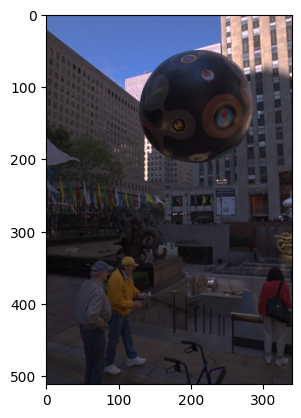

In [106]:
plt.imshow(image)

In [147]:
enhanced_image_512.shape

torch.Size([1, 512, 340, 3])

In [148]:
original_image.shape

torch.Size([1, 512, 340, 3])

In [151]:
enhanced_image_512

tensor([[[[0.6967, 0.6963, 0.7005],
          [0.6967, 0.6963, 0.7005],
          [0.6687, 0.6683, 0.6723],
          ...,
          [0.2485, 0.2478, 0.2487],
          [0.4797, 0.4783, 0.4791],
          [0.7596, 0.7596, 0.7596]],

         [[0.6644, 0.6640, 0.6680],
          [0.6644, 0.6640, 0.6680],
          [0.7036, 0.7032, 0.7074],
          ...,
          [0.2690, 0.2683, 0.2693],
          [0.4360, 0.4347, 0.4356],
          [0.7596, 0.7596, 0.7596]],

         [[0.6686, 0.6683, 0.6722],
          [0.6686, 0.6683, 0.6722],
          [0.7035, 0.7031, 0.7073],
          ...,
          [0.2728, 0.2723, 0.2733],
          [0.3218, 0.3211, 0.3221],
          [0.7596, 0.7596, 0.7596]],

         ...,

         [[0.1825, 0.1822, 0.1830],
          [0.1801, 0.1798, 0.1806],
          [0.1755, 0.1752, 0.1759],
          ...,
          [0.1811, 0.1807, 0.1815],
          [0.1832, 0.1829, 0.1837],
          [0.1832, 0.1829, 0.1837]],

         [[0.1853, 0.1849, 0.1857],
          [0.1829

In [153]:
enhanced =torch.flatten(enhanced_image_512.clone(),start_dim=1, end_dim=-1)
target = torch.flatten(original_image.clone(),start_dim=1, end_dim=-1)

rmse = enhanced-target
rmse = torch.pow(rmse,2).mean(1)


In [154]:
rmse

tensor([0.0097])

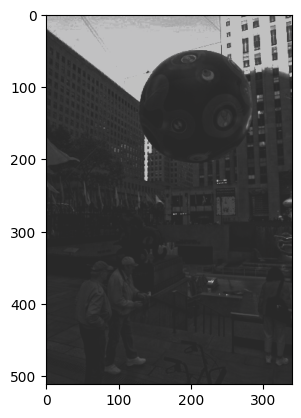

In [142]:
plt.imshow(enhanced_image_512[0])